In [3]:
%pip install pandas
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Problem Description

This project is meant to build an image classification model capable of distinguishing between 10 different animal categories using the [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10/data) dataset. I will be using Convolutional Neural Networks (CNNs) for modeling since they work well with image data. The goal is to train a model that generalizes well to unseen images and provides high classification accuracy.

This project will involve:
- Performing exploratory data analysis (EDA) to understand class distributions and image characteristics.
- Training baseline CNN models from scratch.
- Applying transfer learning with pre-trained models (e.g., VGG16, ResNet50).
- Comparing architectures and tuning hyperparameters to find the best configuration.
- Visualizing performance using metrics, plots, and confusion matrices.

## Dataset Description

The dataset used is the Animals-10 dataset, available on Kaggle. It contains images of 10 different animal categories:

- Butterfly
- Cat
- Chicken
- Cow
- Dog
- Elephant
- Horse
- Sheep
- Spider
- Squirrel

### Key Characteristics:
- **Folder structure**: Images are organized into folders, one per class.
- **Image format**: JPG images with varying resolutions.
- **Class balance**: The number of images per class is imbalanced, with some categories having significantly more samples than others.

The dataset is suitable for multi-class image classification and is ideal for testing CNN and transfer learning approaches due to its diversity and complexity. I will be loading images into a dataset after applying their true label, which is the same as the folder they are contained in.


In [4]:
import glob
import os
import pandas as pd

data_dir = "data"
image_paths = []
labels = []

for label in sorted(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        jpg_files = glob.glob(os.path.join(class_dir, "*.jpg"))
        jpeg_files = glob.glob(os.path.join(class_dir, "*.jpeg"))
        files = jpg_files + jpeg_files
        image_paths.extend(files)
        labels.extend([label] * len(files))

df = pd.DataFrame({"filepath": image_paths, "label": labels})
print(df.head())
print(f"\nTotal images: {len(df)}")


                                            filepath      label
0  data/butterfly/ea37b10e20f2053ed1584d05fb1d4e9...  butterfly
1  data/butterfly/ea36b30f2cf0083ed1584d05fb1d4e9...  butterfly
2  data/butterfly/eb3db2082dfc083ed1584d05fb1d4e9...  butterfly
3  data/butterfly/e831b10b2ee90021d85a5854ee45429...  butterfly
4  data/butterfly/ea35b80a2ef1043ed1584d05fb1d4e9...  butterfly

Total images: 26128


There is a total of 26128 images with various resolutions.

In [ ]:
import os
from PIL import Image
from collections import Counter

resolutions = []

for label in sorted(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.lower().endswith((".jpg", ".jpeg")):
                img_path = os.path.join(class_dir, file)
                with Image.open(img_path) as img:
                    resolutions.append(img.size)

res_counts = Counter(resolutions)
res_df = pd.DataFrame(res_counts.items(), columns=["Resolution", "Count"])
res_df["Resolution"] = res_df["Resolution"].apply(lambda x: f"{x[0]}×{x[1]}")
res_df = res_df.sort_values("Count", ascending=False)


In [ ]:
top_n = 10
res_df_top = res_df.head(top_n).copy()
other_count = res_df["Count"][top_n:].sum()
res_df_top.loc[len(res_df_top)] = ["Other", other_count]


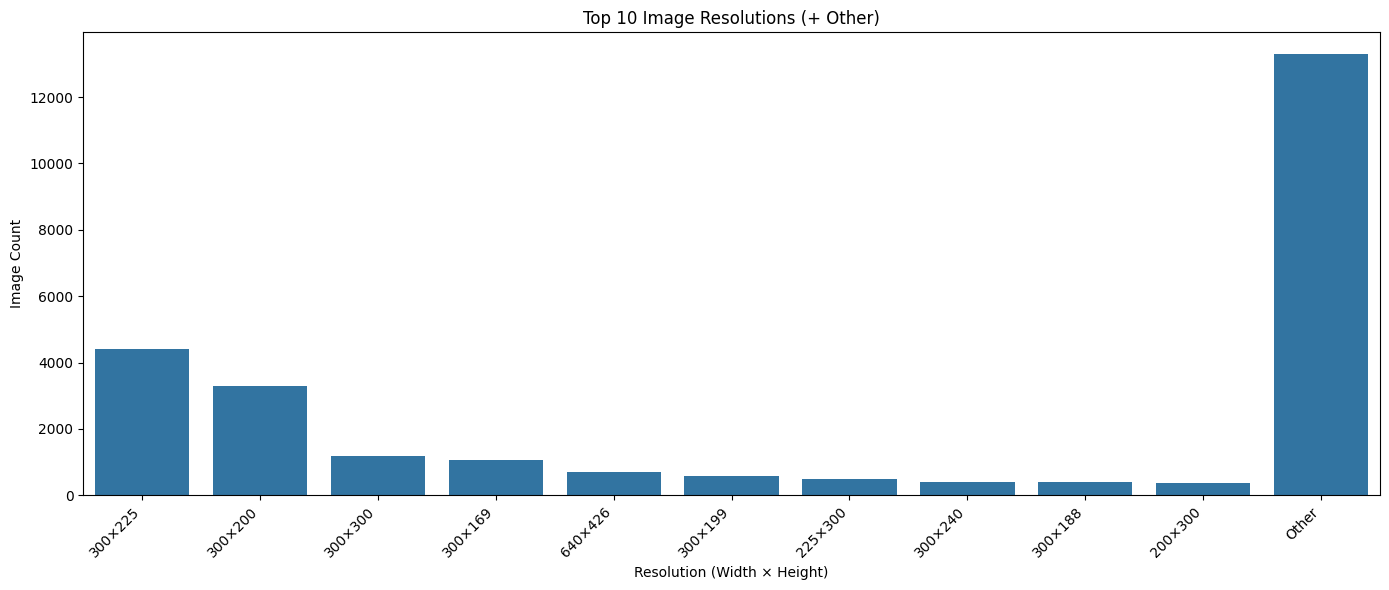

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=res_df_top, x="Resolution", y="Count")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Image Resolutions (+ Other)")
plt.xlabel("Resolution (Width × Height)")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


There is a wide variety of resolutions for these images Above is a histogram to show the 10 most common image resolutions found in the dataset along with another bucket for other resolutions, each would be smaller than the smallest bucket here.

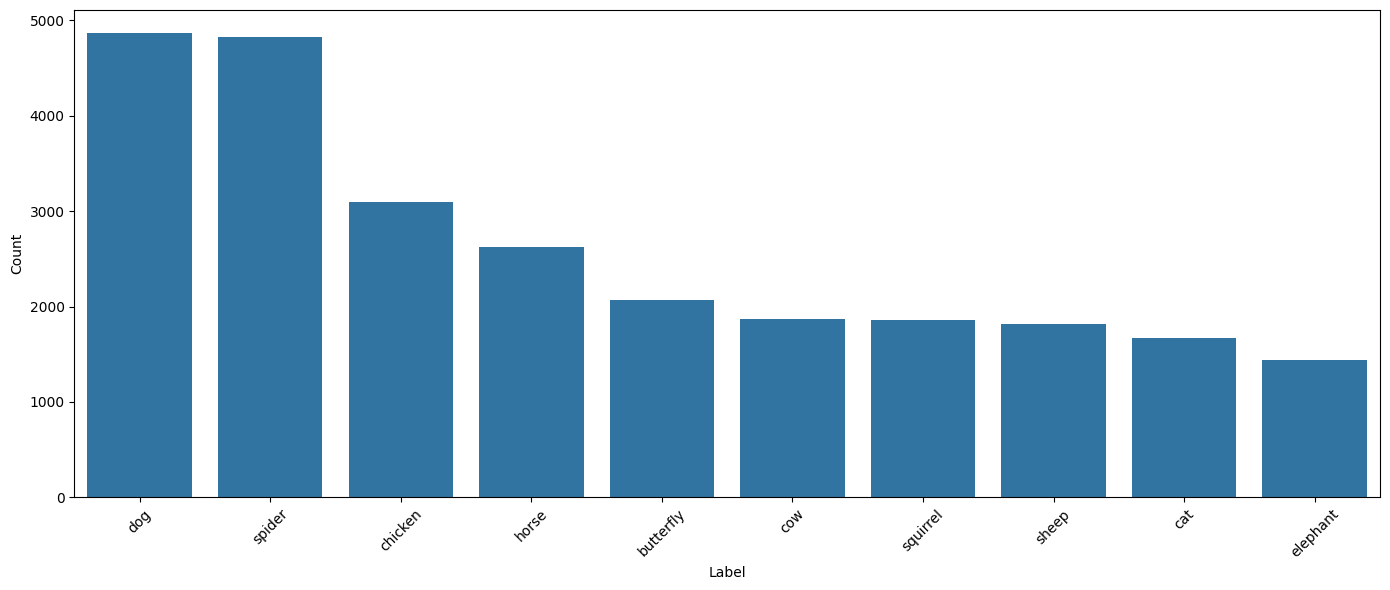

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()


Checking the graph above, you can see the distribution of images across animal classes. I expect the model to perform better for the dog and spider classes, since there is more data to train them on.

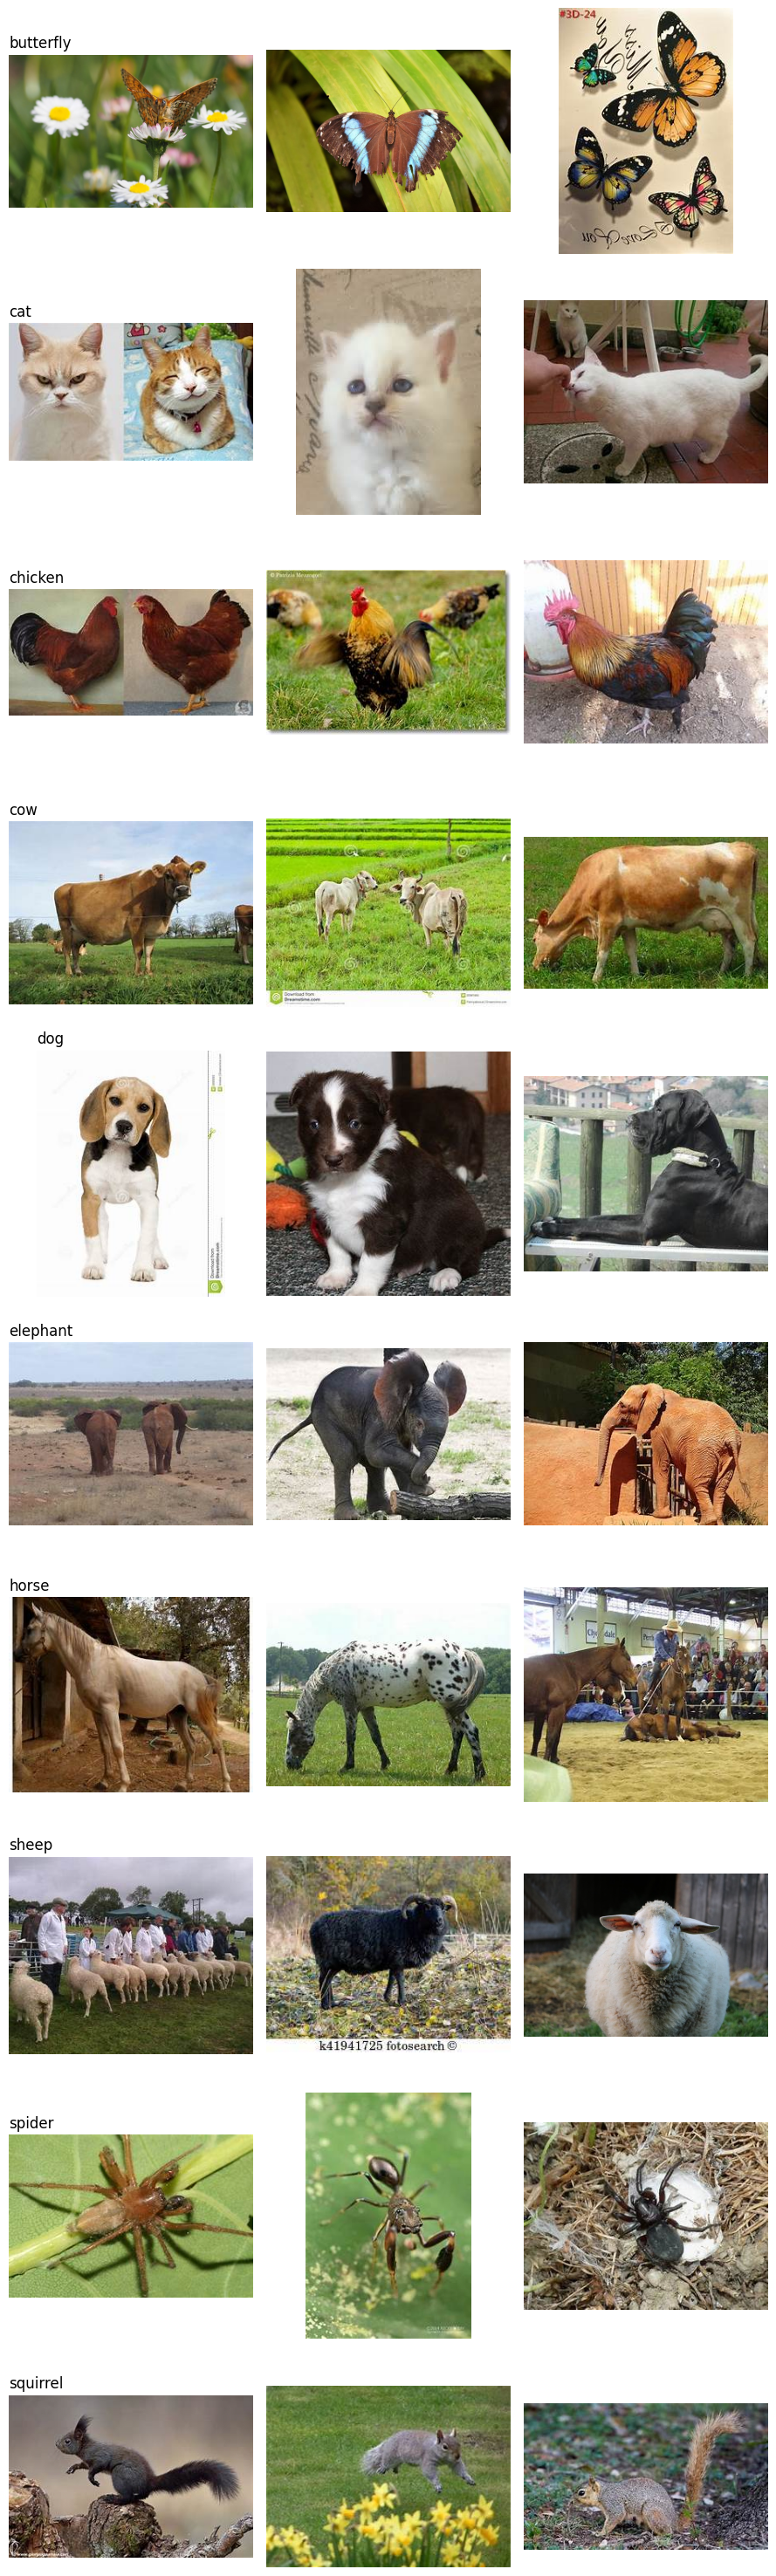

In [4]:
from PIL import Image

image_count = 3
labels = sorted(df["label"].unique())
fig, axes = plt.subplots(len(labels), image_count, figsize=(image_count * 3, len(labels) * 3))

for x_index, label in enumerate(labels):
    samples = df[df["label"] == label].sample(image_count, random_state=111)
    for y_index, path in enumerate(samples["filepath"]):
        image = Image.open(path)
        axes[x_index, y_index].imshow(image)
        axes[x_index, y_index].axis("off")
        if y_index == 0:
            axes[x_index, y_index].set_title(label, fontsize=12, loc="left")
plt.tight_layout()


Here are a few images from each of the classes. You can see how some images contain multiple animals of the same class (two cats, two chickens, two cows, etc) and also that some images contain more than just the classified animal. For example, there are humans in the pictures with sheep and horses. I expect that to cause some confusion for the model, especially for the simple baseline CNN. The transfer learning models should perform better as they should surface latent features more effectively.

## Strategy Based on EDA

From the exploratory data analysis, I'll keep in mind the following things:

1. **Class Imbalance**  
   Some classes have significantly more images than others, which can lead to biased training. This would cause the underrepresented classes to perform worse. This would be a case that accuracy may be high, but recall may be low.

2. **Visual Diversity**  
   A deep CNN is appropriate for capturing complex patterns. Given the limited number of samples for some classes, transfer learning with pre-trained models (e.g., VGG16, ResNet50) will likely perform better than training from scratch.

3. **Multi-Classification**
   There are 10 categories that the image could fit under, so I want to map to one output of those categories. I'll be using the softmax activation function in the output of the CNNs and the categorical_crossentropy loss function during training.

### Plan
- Start with a simple CNN model to establish a baseline.
- Introduce transfer learning using pre-trained models to boost performance.
- Compare results from multiple architectures.
- Perform hyperparameter tuning on the best model.
- Softmax activation function with categorical cross entropy loss function.


## Model Architecture and Justification

I'll begin with a **baseline CNN model** built from scratch using Keras. The architecture includes:

- **Input Layer**: Resized RGB images
- **Convolutional Layers**: Extract spatial features using filters
- **MaxPooling Layers**: Downsample feature maps to reduce dimensionality
- **Dropout**: Prevent overfitting
- **Flatten Layer**: Converts 2D features into 1D
- **Dense Layers**: Fully connected layers for final classification

### Baseline Architecture:
- Conv2D(32) → MaxPool
- Conv2D(64) → MaxPool
- Flatten → Dense(128) → Dropout(0.5)
- Output: Dense(10, softmax)

### Baseline Architecture:
- **Conv2D(32) → MaxPool**: Extracts low-level, simple features (edges, textures) and reduces spatial dimensions.
- **Conv2D(64) → MaxPool**: Captures more complex patterns and further reduces dimensions.
- **Flatten → Dense(128)**: Flattens feature maps and connects to a fully connected layer to learn high-level representations.
- **Dropout(0.5)**: Randomly drops 50% of perceptrons during training to reduce overfitting.
- **Output: Dense(10, softmax)**: Outputs class probabilities across the 10 categories.

This model is simple yet powerful enough to establish a performance baseline. It allows us to:
- Quickly test end-to-end pipeline
- Benchmark improvements from transfer learning
- Understand training dynamics (overfitting, convergence)

I'll later compare this against transfer learning models like VGG16 and ResNet50 to evaluate gains from pre-trained feature extractors.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Train/valid/test split
train_df, test_df = train_test_split(df, stratify=df['label_encoded'], test_size=0.2, random_state=222)
train_df, valid_df = train_test_split(train_df, stratify=train_df['label_encoded'], test_size=0.1, random_state=333)

# Image generators
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
rescale = 1.0 / 255

train_generator = ImageDataGenerator(rescale=rescale, horizontal_flip=True, rotation_range=20)
valid_generator = ImageDataGenerator(rescale=rescale)
test_generator = ImageDataGenerator(rescale=rescale)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

/Users/mikebrozowski/animal-recognition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Preprocessing

I used Keras' `ImageDataGenerator` to handle image preprocessing. Under the hood, it:
- **Resizes** all images to a fixed input shape (128×128) expected by the model.
- **Rescales pixel values** to [0, 1] (normalized) or applies model-specific preprocessing.
- **Applies augmentations** like flipping or rotation during training to improve generalization.
- **Batches and shuffles** the data efficiently for training and validation.


In [ ]:
train_loader_base = train_generator.flow_from_dataframe(train_df, x_col="filepath", y_col="label",
                                             target_size=IMG_SIZE, class_mode="categorical",
                                             batch_size=BATCH_SIZE, shuffle=True)

valid_loader_base = valid_generator.flow_from_dataframe(valid_df, x_col="filepath", y_col="label",
                                         target_size=IMG_SIZE, class_mode="categorical",
                                         batch_size=BATCH_SIZE, shuffle=False)

test_loader_base = test_generator.flow_from_dataframe(test_df, x_col="filepath", y_col="label",
                                           target_size=IMG_SIZE, class_mode="categorical",
                                           batch_size=BATCH_SIZE, shuffle=False)


Found 18811 validated image filenames belonging to 10 classes.
Found 2091 validated image filenames belonging to 10 classes.
Found 5226 validated image filenames belonging to 10 classes.


In [7]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,818 (56.33 MB)

 Trainable params: 14,767,818 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_loader_base,
    validation_data=valid_loader_base,
    epochs=10,
    callbacks=callbacks,
)


Epoch 1/10


/Users/mikebrozowski/animal-recognition/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.2587 - loss: 2.2770 - val_accuracy: 0.4299 - val_loss: 1.7143 - learning_rate: 0.0010
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.4319 - loss: 1.6418 - val_accuracy: 0.4940 - val_loss: 1.5255 - learning_rate: 0.0010
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.4984 - loss: 1.4669 - val_accuracy: 0.5146 - val_loss: 1.4663 - learning_rate: 0.0010
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.5284 - loss: 1.3682 - val_accuracy: 0.5591 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.5591 - loss: 1.2986 - val_accuracy: 0.5768 - val_loss: 1.2820 - learning_rate: 0.0010
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.5744 - loss: 1.2602 - val_accuracy: 0.5768 - val_loss: 1.3264 - learning_rate: 0.0010
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.5986 - loss: 1.1731

In [9]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Use preprocess_input for VGG16
train_generator_vgg = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, rotation_range=20)
valid_generator_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_loader_vgg = train_generator_vgg.flow_from_dataframe(train_df, x_col="filepath", y_col="label",
                                                     target_size=IMG_SIZE, class_mode="categorical",
                                                     batch_size=BATCH_SIZE, shuffle=True)
valid_loader_vgg = valid_generator_vgg.flow_from_dataframe(valid_df, x_col="filepath", y_col="label",
                                                 target_size=IMG_SIZE, class_mode="categorical",
                                                 batch_size=BATCH_SIZE, shuffle=False)
test_loader_vgg = test_generator_vgg.flow_from_dataframe(test_df, x_col="filepath", y_col="label",
                                                   target_size=IMG_SIZE, class_mode="categorical",
                                                   batch_size=BATCH_SIZE, shuffle=False)


Found 18811 validated image filenames belonging to 10 classes.
Found 2091 validated image filenames belonging to 10 classes.
Found 5226 validated image filenames belonging to 10 classes.


In [10]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,814,666 (64.14 MB)

 Trainable params: 2,099,978 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
history_vgg = vgg_model.fit(
    train_loader_vgg,
    validation_data=valid_loader_vgg,
    epochs=10,
    callbacks=callbacks,
)


Epoch 1/10


/Users/mikebrozowski/animal-recognition/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 232s 393ms/step - accuracy: 0.6123 - loss: 5.3468 - val_accuracy: 0.8264 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 229s 389ms/step - accuracy: 0.7173 - loss: 1.0229 - val_accuracy: 0.8627 - val_loss: 0.5215 - learning_rate: 0.0010
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 230s 390ms/step - accuracy: 0.7361 - loss: 0.9315 - val_accuracy: 0.8723 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 224s 382ms/step - accuracy: 0.7759 - loss: 0.7641 - val_accuracy: 0.8742 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.7901 - loss: 0.7454 - val_accuracy: 0.8737 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 221s 375ms/step - accuracy: 0.7980 - loss: 0.6669 - val_accuracy: 0.8828 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 214s 364ms/step - accuracy: 0.8106 

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

# Use ResNet preprocessed input
train_generator_resnet = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, rotation_range=20)
valid_generator_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_loader_resnet = train_generator_resnet.flow_from_dataframe(train_df, x_col="filepath", y_col="label",
                                                           target_size=IMG_SIZE, class_mode="categorical",
                                                           batch_size=BATCH_SIZE, shuffle=True)
valid_loader_resnet = valid_generator_resnet.flow_from_dataframe(valid_df, x_col="filepath", y_col="label",
                                                       target_size=IMG_SIZE, class_mode="categorical",
                                                       batch_size=BATCH_SIZE, shuffle=False)
test_loader_resnet = test_generator_resnet.flow_from_dataframe(test_df, x_col="filepath", y_col="label",
                                                         target_size=IMG_SIZE, class_mode="categorical",
                                                         batch_size=BATCH_SIZE, shuffle=False)


Found 18811 validated image filenames belonging to 10 classes.
Found 2091 validated image filenames belonging to 10 classes.
Found 5226 validated image filenames belonging to 10 classes.


In [13]:
from tensorflow.keras.applications import ResNet50

base_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
base_resnet.trainable = False

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
history_resnet = resnet_model.fit(
    train_loader_resnet,
    validation_data=valid_loader_resnet,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


/Users/mikebrozowski/animal-recognition/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 101s 168ms/step - accuracy: 0.7507 - loss: 0.9084 - val_accuracy: 0.9072 - val_loss: 0.2843 - learning_rate: 0.0010
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 97s 164ms/step - accuracy: 0.8601 - loss: 0.4364 - val_accuracy: 0.9106 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 96s 164ms/step - accuracy: 0.8742 - loss: 0.3934 - val_accuracy: 0.9168 - val_loss: 0.2588 - learning_rate: 0.0010
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 97s 166ms/step - accuracy: 0.8904 - loss: 0.3453 - val_accuracy: 0.9120 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 98s 167ms/step - accuracy: 0.8909 - loss: 0.3453 - val_accuracy: 0.9225 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 96s 164ms/step - accuracy: 0.8927 - loss: 0.3333 - val_accuracy: 0.9197 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8973 - loss:

In [15]:
import numpy as np

def evaluate_and_predict(model, test_loader):
    loss, acc = model.evaluate(test_loader, verbose=0)
    y_true = test_loader.classes
    y_pred = model.predict(test_loader, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return acc, loss, y_true, y_pred_labels

baseline_acc, baseline_loss, y_true_base, y_pred_base = evaluate_and_predict(model, test_loader_base)
vgg_acc, vgg_loss, y_true_vgg, y_pred_vgg = evaluate_and_predict(vgg_model, test_loader_vgg)
resnet_acc, resnet_loss, y_true_resnet, y_pred_resnet = evaluate_and_predict(resnet_model, test_loader_resnet)


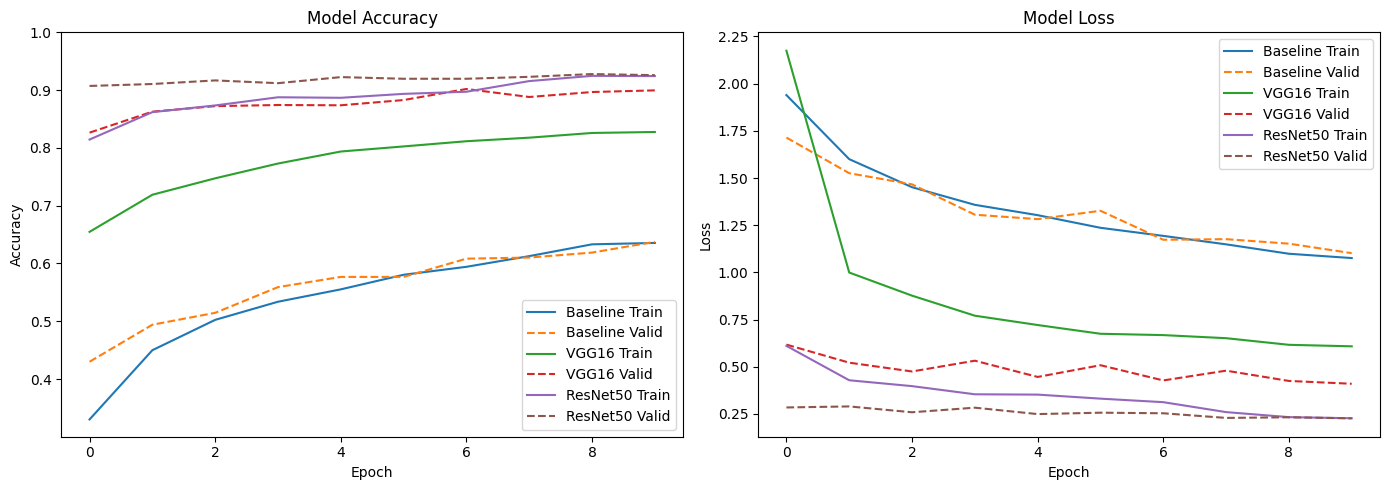

In [34]:
def plot_history(histories, labels):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for hist, label in zip(histories, labels):
        axes[0].plot(hist.history['accuracy'], label=f'{label} Train')
        axes[0].plot(hist.history['val_accuracy'], linestyle='--', label=f'{label} Valid')

        axes[1].plot(hist.history['loss'], label=f'{label} Train')
        axes[1].plot(hist.history['val_loss'], linestyle='--', label=f'{label} Valid')

    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(top=1)
    axes[0].legend()

    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_history([history, history_vgg, history_resnet], ['Baseline', 'VGG16', 'ResNet50'])


In [17]:
import pandas as pd

summary = pd.DataFrame({
    "Model": ["Baseline CNN", "VGG16", "ResNet50"],
    "Test Accuracy": [baseline_acc, vgg_acc, resnet_acc],
    "Test Loss": [baseline_loss, vgg_loss, resnet_loss]
})
print(summary.sort_values("Test Accuracy", ascending=False))


          Model  Test Accuracy  Test Loss
2      ResNet50       0.921163   0.256783
1         VGG16       0.894183   0.508309
0  Baseline CNN       0.617489   1.122779


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# True and predicted labels
class_names = test_loader_base.class_indices
class_labels = list(class_names.keys())

              precision    recall  f1-score   support

   butterfly       0.60      0.87      0.71       414
         cat       0.67      0.21      0.32       333
     chicken       0.68      0.75      0.72       620
         cow       0.44      0.53      0.48       373
         dog       0.66      0.61      0.63       973
    elephant       0.55      0.60      0.58       288
       horse       0.55      0.67      0.60       525
       sheep       0.44      0.53      0.48       364
      spider       0.82      0.69      0.75       964
    squirrel       0.56      0.41      0.48       372

    accuracy                           0.62      5226
   macro avg       0.60      0.59      0.57      5226
weighted avg       0.63      0.62      0.61      5226



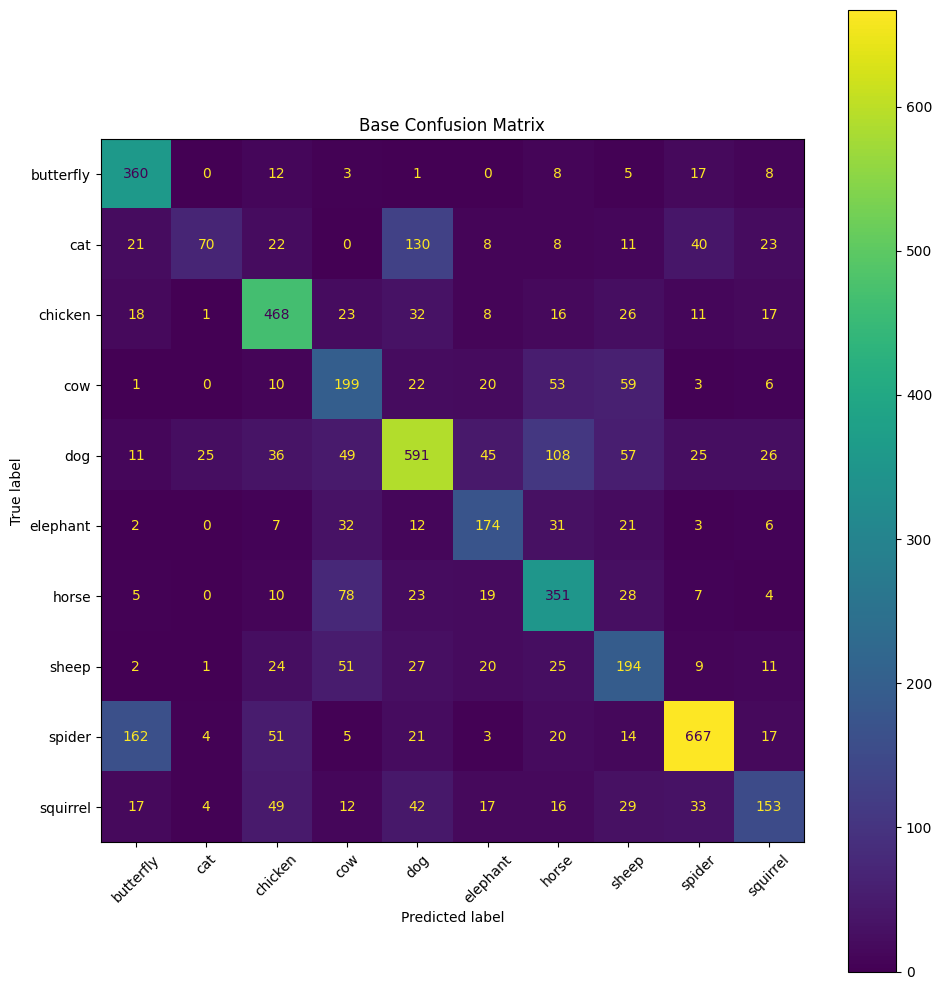

In [19]:
# Classification report
print(classification_report(y_true_base, y_pred_base, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true_base, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Base Confusion Matrix")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

   butterfly       0.92      0.93      0.93       414
         cat       0.93      0.79      0.85       333
     chicken       0.95      0.92      0.93       620
         cow       0.77      0.86      0.81       373
         dog       0.85      0.90      0.87       973
    elephant       0.94      0.90      0.92       288
       horse       0.86      0.85      0.85       525
       sheep       0.86      0.79      0.82       364
      spider       0.96      0.96      0.96       964
    squirrel       0.90      0.91      0.90       372

    accuracy                           0.89      5226
   macro avg       0.89      0.88      0.89      5226
weighted avg       0.90      0.89      0.89      5226



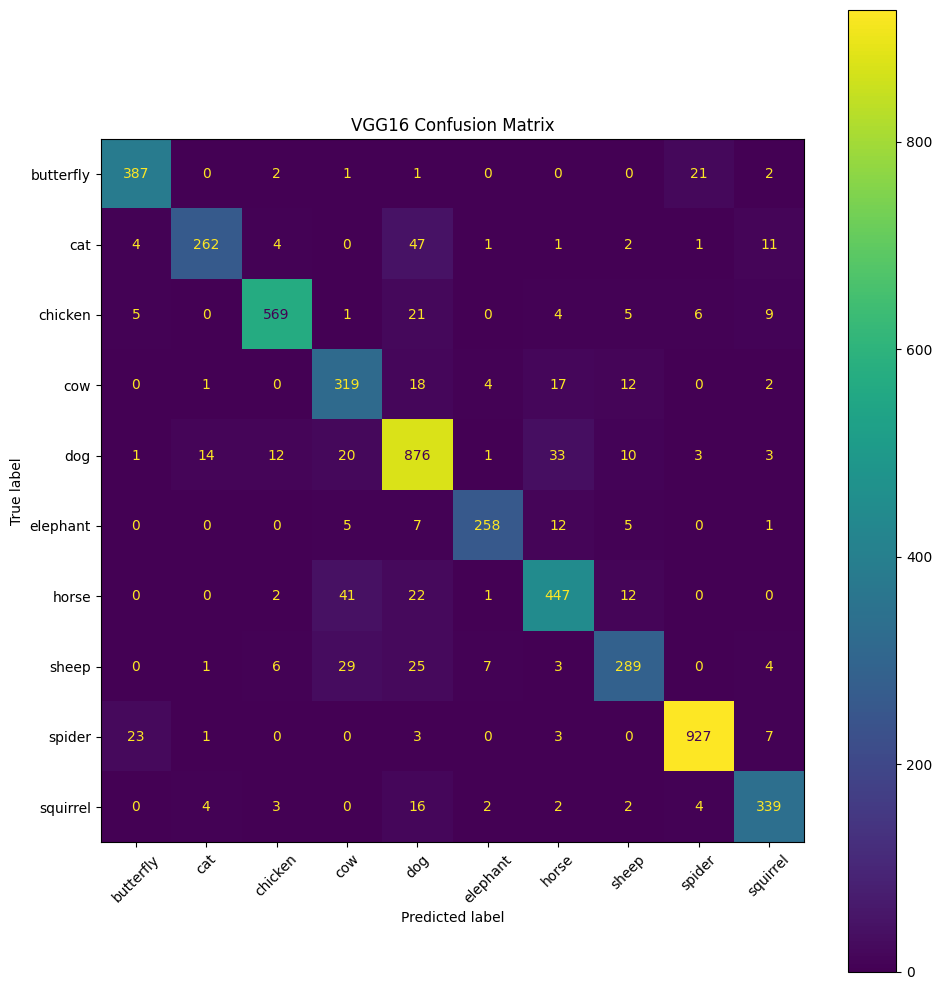

In [20]:
# Classification report
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("VGG16 Confusion Matrix")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

   butterfly       0.94      0.94      0.94       414
         cat       0.89      0.89      0.89       333
     chicken       0.96      0.95      0.96       620
         cow       0.83      0.85      0.84       373
         dog       0.92      0.93      0.93       973
    elephant       0.95      0.93      0.94       288
       horse       0.92      0.88      0.90       525
       sheep       0.83      0.90      0.86       364
      spider       0.96      0.97      0.97       964
    squirrel       0.94      0.87      0.90       372

    accuracy                           0.92      5226
   macro avg       0.91      0.91      0.91      5226
weighted avg       0.92      0.92      0.92      5226



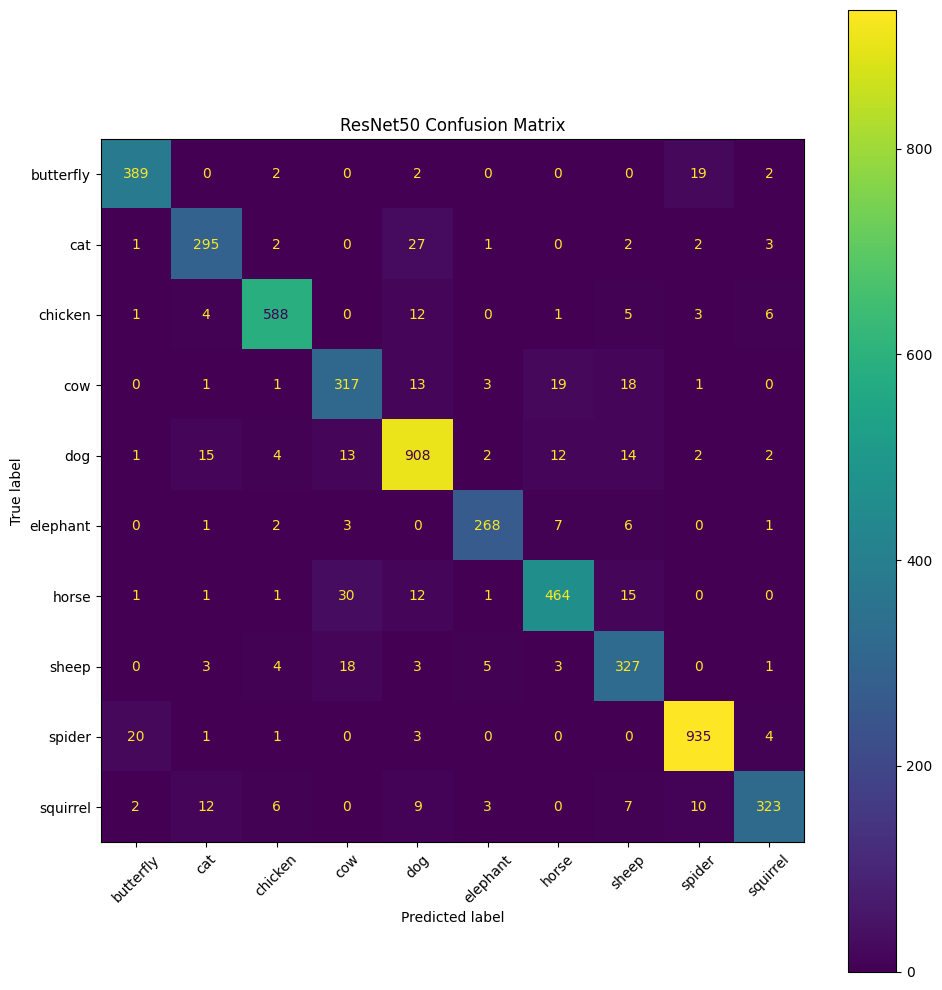

In [21]:
# Classification report
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true_resnet, y_pred_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("ResNet50 Confusion Matrix")
plt.tight_layout()
plt.show()

### Evaluation Metrics

- **Accuracy/Loss Charts**: First the charts show how well the model learns over time. A gap between training and validation curves can indicate overfitting.
- **Classification Report**: Gives additional metrics like precision, recall, and F1-score per class, which highlight performance across imbalanced categories.
- **Confusion Matrix**: Visualizes prediction errors — strong diagonals indicate good performance; off-diagonals show misclassifications. Only the base model appears to have issues keeping a strong diagonal.

## Hyperparameter Tuning Strategy

Based on evaluation results, **ResNet50** significantly outperformed the baseline CNN and VGG16 models. Therefore, we will proceed with **ResNet50** as the base architecture and focus on tuning its hyperparameters to further improve performance.

### Tuning Plan

I will train three variations of the ResNet50 model:

1. **Unfrozen Layers**  
   - Unfreeze the last few layers of the ResNet50 base to allow fine-tuning of pre-trained weights.
   - Use the same optimizer (`Adam`) with a lower learning rate.

2. **Change Optimizer**  
   - Keep the ResNet50 base frozen.
   - Replace `Adam` with `SGD` optimizer using momentum, which may improve convergence for fine-tuning.

3. **Unfrozen + SGD**  
   - Unfreeze the last few layers of the base model.
   - Use `SGD` with momentum and a reduced learning rate for stable updates.

Each variation will be trained with callbacks for early stopping and learning rate reduction. I'll compare performance across these variants and select the best configuration based on validation and test accuracy.


In [22]:
import tensorflow as tf

# Unfreeze last 30 layers
base1 = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in base1.layers[:-30]:
    layer.trainable = False

model1 = models.Sequential([
    base1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

history1 = model1.fit(train_loader_resnet, validation_data=valid_loader_resnet, epochs=10, callbacks=callbacks)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 14,977,290 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 162s 270ms/step - accuracy: 0.7387 - loss: 0.8460 - val_accuracy: 0.9259 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 157s 266ms/step - accuracy: 0.9210 - loss: 0.2508 - val_accuracy: 0.9321 - val_loss: 0.2176 - learning_rate: 1.0000e-04
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9465 - loss: 0.1676
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
588/588 ━━━━━━━━━━━━━━━━━━━━ 157s 267ms/step - accuracy: 0.9465 - loss: 0.1676 - val_accuracy: 0.9287 - val_loss: 0.2263 - learning_rate: 1.0000e-04
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 158s 268ms/step - accuracy: 0.9646 - loss: 0.1202 - val_accuracy: 0.9503 - val_loss: 0.1726 - learning_rate: 2.0000e-05
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 158s 269ms/step - accuracy: 0.9764 - loss: 0.0778 - val_accuracy: 0.9503 - val_loss: 0.1780 - learning_rate: 2.0000e-05
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 254

In [23]:
base2 = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
base2.trainable = False

model2 = models.Sequential([
    base2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
               loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

history2 = model2.fit(train_loader_resnet, validation_data=valid_loader_resnet, epochs=10, callbacks=callbacks)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 93s 155ms/step - accuracy: 0.4377 - loss: 2.1967 - val_accuracy: 0.8556 - val_loss: 0.4682 - learning_rate: 1.0000e-04
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - accuracy: 0.7605 - loss: 0.7440 - val_accuracy: 0.8780 - val_loss: 0.3817 - learning_rate: 1.0000e-04
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 95s 161ms/step - accuracy: 0.8032 - loss: 0.6122 - val_accuracy: 0.8838 - val_loss: 0.3501 - learning_rate: 1.0000e-04
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 93s 159ms/step - accuracy: 0.8265 - loss: 0.5368 - val_accuracy: 0.8914 - val_loss: 0.3272 - learning_rate: 1.0000e-04
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - accuracy: 0.8319 - loss: 0.5129 - val_accuracy: 0.8929 - val_loss: 0.3147 - learning_rate: 1.0000e-04
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - accuracy: 0.8391 - loss: 0.4920 - val_accuracy: 0.8972 - val_loss: 0.3023 - learning_rate: 1.0000e-04
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 94s 16

In [24]:
base3 = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in base3.layers[:-30]:
    layer.trainable = False

model3 = models.Sequential([
    base3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
               loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

history3 = model3.fit(train_loader_resnet, validation_data=valid_loader_resnet, epochs=10, callbacks=callbacks)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 14,977,290 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 152s 256ms/step - accuracy: 0.3921 - loss: 1.9775 - val_accuracy: 0.8560 - val_loss: 0.4695 - learning_rate: 1.0000e-04
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 148s 252ms/step - accuracy: 0.7746 - loss: 0.6931 - val_accuracy: 0.8905 - val_loss: 0.3432 - learning_rate: 1.0000e-04
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 149s 253ms/step - accuracy: 0.8261 - loss: 0.5355 - val_accuracy: 0.9082 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 148s 251ms/step - accuracy: 0.8518 - loss: 0.4506 - val_accuracy: 0.9125 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 147s 250ms/step - accuracy: 0.8676 - loss: 0.4114 - val_accuracy: 0.9187 - val_loss: 0.2485 - learning_rate: 1.0000e-04
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 146s 249ms/step - accuracy: 0.8878 - loss: 0.3563 - val_accuracy: 0.9177 - val_loss: 0.2382 - learning_rate: 1.0000e-04
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
def evaluate_model(model, loader):
    loss, acc = model.evaluate(loader, verbose=0)
    preds = model.predict(loader, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    return acc, loss, y_pred

acc1, loss1, y_pred1 = evaluate_model(model1, test_loader_resnet)
acc2, loss2, y_pred2 = evaluate_model(model2, test_loader_resnet)
acc3, loss3, y_pred3 = evaluate_model(model3, test_loader_resnet)
y_true = test_loader_resnet.classes


In [32]:
results_df = pd.DataFrame({
    "Model": [
        "ResNet50 (Unfrozen + Adam)",
        "ResNet50 (Frozen + SGD)",
        "ResNet50 (Unfroze + SGD)"
    ],
    "Test Accuracy": [acc1, acc2, acc3],
    "Test Loss": [loss1, loss2, loss3]
}).sort_values("Test Accuracy", ascending=False)

print(results_df)


                        Model  Test Accuracy  Test Loss
0  ResNet50 (Unfrozen + Adam)       0.942786   0.213152
2    ResNet50 (Unfroze + SGD)       0.926521   0.242345
1     ResNet50 (Frozen + SGD)       0.901263   0.291952


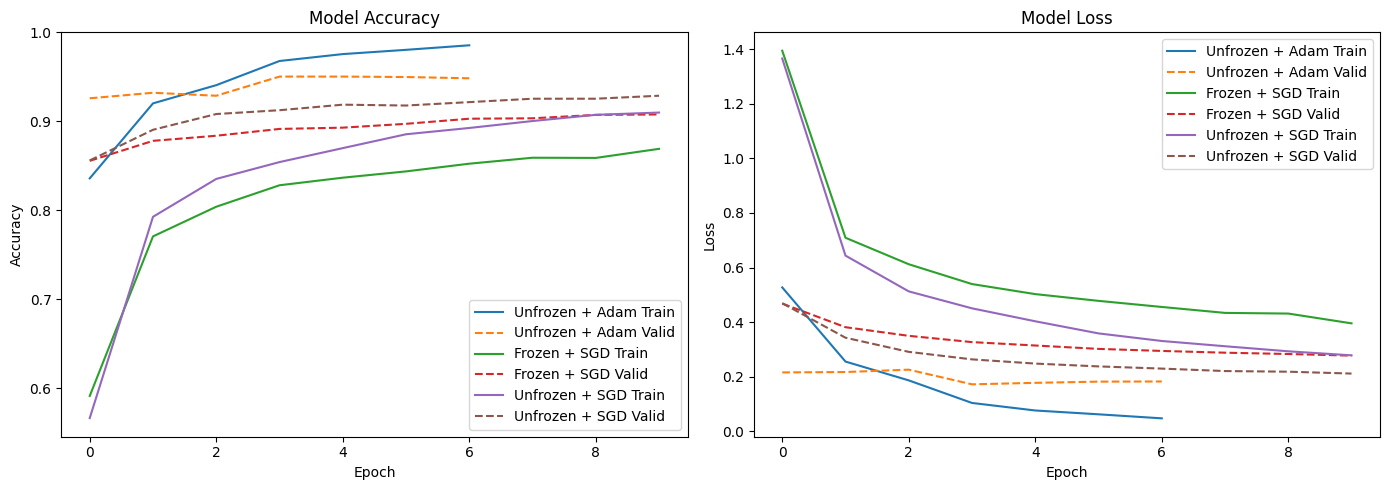

In [35]:
plot_history([history1, history2, history3], ['Unfrozen + Adam', 'Frozen + SGD', 'Unfrozen + SGD'])

              precision    recall  f1-score   support

   butterfly       0.90      0.97      0.93       414
         cat       0.92      0.90      0.91       333
     chicken       0.97      0.97      0.97       620
         cow       0.88      0.92      0.90       373
         dog       0.95      0.94      0.95       973
    elephant       0.93      0.95      0.94       288
       horse       0.94      0.93      0.94       525
       sheep       0.91      0.90      0.90       364
      spider       0.97      0.96      0.97       964
    squirrel       0.98      0.94      0.96       372

    accuracy                           0.94      5226
   macro avg       0.94      0.94      0.94      5226
weighted avg       0.94      0.94      0.94      5226



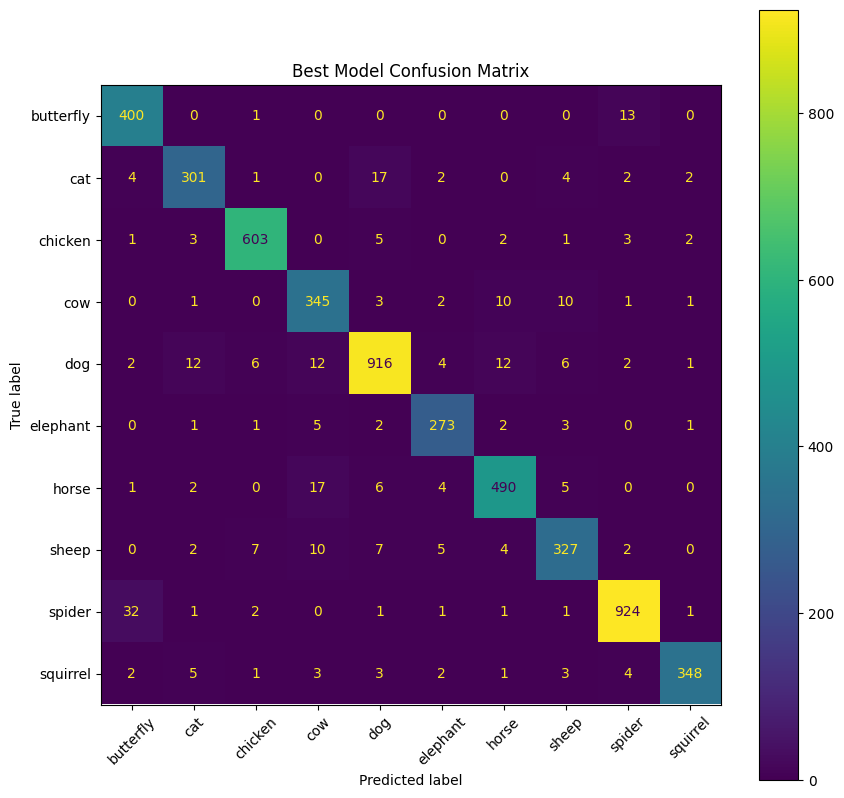

In [ ]:
# y_pred1 = Unfrozen + Adam predictions

best_pred = [y_pred1, y_pred2, y_pred3][results_df.index[0]]

print(classification_report(y_true_resnet, best_pred, target_names=class_labels))

cm = confusion_matrix(y_true, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader_resnet.class_indices.keys())
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Best Model Confusion Matrix")
plt.show()


### What Went Well
- **Transfer Learning Boost**: Using pre-trained models (VGG16, ResNet50) provided a significant accuracy improvement over the baseline CNN.
- **Fine-Tuning ResNet50**: Unfreezing the last few layers and using the Adam optimizer led to the best test accuracy, showing the benefit of controlled fine-tuning.
- **Callbacks**: Early stopping and learning rate reduction helped avoid overfitting and improved training stability.
- **Data Augmentation**: Mild augmentations improved generalization without introducing noise.

### What Didn’t Work Well
- **Baseline CNN**: Training a model from scratch performed poorly (~60% accuracy), likely due to insufficient depth and no pre-learned features.
- **Frozen ResNet50 + SGD**: This combination underperformed; it lacked the adaptability needed for our dataset despite stable optimization.
- **Limited Label Balance**: Class imbalance remained a challenge, especially in rare classes, impacting overall accuracy and precision.

In summary, ResNet50 with fine-tuning and SGD gave the best trade-off between performance and generalization.

### What I Would Do Differently
- **Explore More Architectures**: There are many CNNs out there to support more transfer learning. I would explore a variety of those (EfficientNet, MobileNet).
- **Unit Size Tuning**: Experiment with different dense layer sizes (128, 256, 512) to better balance model capacity and generalization.


## Hyperparameter Differences and Optimization Summary

To optimize model performance, I systematically varied key hyperparameters across different configurations of ResNet50:

| Model Variant                    | Trainable Layers | Optimizer        | Learning Rate | Dropout | Dense Units | Test Accuracy |
|----------------------------------|------------------|------------------|---------------|---------|--------------|----------------|
| ResNet50 (Frozen)                | No               | Adam             | 1e-3          | 0.5     | 256          | ~92%       |
| ResNet50 (Unfreeze + Adam)       | Last 30          | Adam             | 1e-4          | 0.5     | 256          | ~94%       |
| ResNet50 (Frozen + SGD)          | No               | SGD + Momentum   | 1e-4          | 0.5     | 256          | ~90%          |
| ResNet50 (Unfreeze + SGD)      | Last 30          | SGD + Momentum   | 1e-4          | 0.5     | 256          | ~93%           |

### Insights
- **Lower Learning Rate** was necessary for fine-tuning without overfitting.
- **Adam** provided smoother convergence compared to SGD + Momentum for fine-tuning.
- **Unfreezing** enabled learning dataset-specific features and improved accuracy.
- **256 units + 0.5 dropout** balanced capacity and regularization.

I observed that the best model used both unfreezing and the Adam optimizer.


## Conclusion

In this project, our approach involved:

- Establishing a baseline using a simple CNN from scratch.
- Leveraging transfer learning with VGG16 and ResNet50.
- Systematically tuning key hyperparameters including trainability, optimizer choice, and learning rate.

### Key Outcomes
- **ResNet50** consistently outperformed other models, especially when fine-tuned with unfreezing and `Adam`.
- **Hyperparameter tuning** made a marginal difference, with small changes (like learning rate and unfreezing) resulting in major accuracy gains.
- **Best model achieved the highest test accuracy**, validating the strategy of transfer learning + fine-tuning for small-to-medium image datasets.

Overall, the project demonstrated the power of pre-trained CNNs and the importance of thoughtful hyperparameter optimization in deep learning workflows.
